## Crypto Trade Flow Predictions
### FINM 33150: Project 3

* Ed H. Tian
* edmundht@uchicago.edu

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as spq
import quandl
import functools
import seaborn as sns
import plotnine as p9p
import datetime
import statsmodels.api as sm

from pandas.tseries.offsets import QuarterEnd

### 1 Introduction

High frequency trading is of great interest among qunatitative finance community and the rise of cryptocurrencies gives rise to a novel landscape where profits can be found via close inspection of tick-level data. In this assignment we will process book and trade data of crytotokens, capture flows and forward returns within given seconds and take advantage of their correlations to create a trading strategy regardless of whether we know what factors drive up asset prices or not. If there is a significant flow, we assume there is going to be price changes in either direction. The objective of this project is to find out the cryptotoken pair in 2023 that has the most significant aforementioned correlations and backtest the performance of this flow-based return prediction trading strategy.

### 2 Data Preparation

In [2]:
book_BTC_USD_2023 = pd.read_csv('Crypto/2023/book_narrow_BTC-USD_2023.delim.gz', compression='gzip', delimiter='\t')
book_ETH_BTC_2023 = pd.read_csv('Crypto/2023/book_narrow_ETH-BTC_2023.delim.gz', compression='gzip', delimiter='\t')
book_ETH_USD_2023 = pd.read_csv('Crypto/2023/book_narrow_ETH-USD_2023.delim.gz', compression='gzip', delimiter='\t')
book_BTC_USD_2023.head(5)

,Ask1PriceMillionths,Bid1PriceMillionths,Ask1SizeBillionths,Bid1SizeBillionths,Ask2PriceMillionths,Bid2PriceMillionths,Ask2SizeBillionths,Bid2SizeBillionths,received_utc_nanoseconds,timestamp_utc_nanoseconds,Mid
0,22972550000,22970150000,210000000,25797600,22972560000,22970120000,210000000,87069610,1674521267750919800,1674521267806932000,2.297135e+10
1,22972550000,22970150000,410000000,25797600,22972560000,22970120000,210000000,87069610,1674521267751154000,1674521267807073000,2.297135e+10
2,22972550000,22970150000,410000000,25797600,22972560000,22970120000,210000000,87069610,1674521267752363000,1674521267813516000,2.297135e+10
3,22972540000,22970150000,210000000,25797600,22972550000,22970120000,410000000,87069610,1674521267763308000,1674521267819272000,2.297134e+10
4,22972540000,22970150000,210000000,25797600,22972550000,22970120000,410000000,87069610,1674521267764161000,1674521267825538000,2.297134e+10


In [3]:
trade_BTC_USD_2023 = pd.read_csv('Crypto/2023/trades_narrow_BTC-USD_2023.delim.gz', compression='gzip', delimiter='\t')
trade_ETH_BTC_2023 = pd.read_csv('Crypto/2023/trades_narrow_ETH-BTC_2023.delim.gz', compression='gzip', delimiter='\t')
trade_ETH_USD_2023 = pd.read_csv('Crypto/2023/trades_narrow_ETH-USD_2023.delim.gz', compression='gzip', delimiter='\t')
trade_BTC_USD_2023.head(5)

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1674521267814309000,1674521267874527000,22970120000,87069600,-1
1,1674521267814046000,1674521267874527000,22970150000,25797600,-1
2,1674521267817981000,1674521267878712000,22970120000,10,-1
3,1674521267822734000,1674521267886114000,22969160000,217683140,-1
4,1674521274845338000,1674521268676444000,22969840000,10000000,1


In [4]:
class Side:
    BUY = 1
    SELL = -1

In [5]:
def book_filter(df):
    book = df.copy()
    book['ask'] = book['Ask1PriceMillionths']/1000000
    book['bid'] = book['Bid1PriceMillionths']/ 1000000
    book['ask_size'] = book['Ask1SizeBillionths']/1000000000
    book['bid_size'] = book['Bid1SizeBillionths']/1000000000
    book['Book datetime'] = pd.to_datetime(book['timestamp_utc_nanoseconds'], unit='ns')
    book.rename(columns = {'timestamp_utc_nanoseconds': 'timestamp_utc_nanoseconds_book'}, inplace = True)
    
    tot_weight = np.sqrt(book['bid_size']) + np.sqrt(book['ask_size'])
    book['owa'] = (np.sqrt(book['bid_size']) / tot_weight) * book['ask'] + (np.sqrt(book['ask_size']) / tot_weight) * book['bid'] 
    return book[['Book datetime', 'timestamp_utc_nanoseconds_book', 'ask', 'bid', 'ask_size', 'bid_size', 'owa']]

In [6]:
def trade_filter(df):
    trade = df.copy()
    # trade['timestamp_utc_nanoseconds'] = pd.to_datetime(trade['timestamp_utc_nanoseconds'], unit = 'ns')
    trade['Transaction Price'] = trade['PriceMillionths'] / 1000000
    trade['Trade datetime'] = pd.to_datetime(df['timestamp_utc_nanoseconds'], unit='ns')
    trade.rename(columns = {'timestamp_utc_nanoseconds': 'timestamp_utc_nanoseconds_trade'}, inplace = True)

    trade['Size'] = trade['SizeBillionths'] / 1000000000
    trade['Side'] = np.where(trade['Side'] > 0, Side.BUY, Side.SELL)
    return trade[['Trade datetime', 'received_utc_nanoseconds', 'timestamp_utc_nanoseconds_trade', 'Transaction Price', 'Size', 'Side']]

In [7]:
filtered_trade_BTC_USD_2023 = trade_filter(trade_BTC_USD_2023)
filtered_trade_ETH_BTC_2023 = trade_filter(trade_ETH_BTC_2023)
filtered_trade_ETH_USD_2023 = trade_filter(trade_ETH_USD_2023)
filtered_book_BTC_USD_2023 = book_filter(book_BTC_USD_2023)
filtered_book_ETH_BTC_2023 = book_filter(book_ETH_BTC_2023)
filtered_book_ETH_USD_2023 = book_filter(book_ETH_USD_2023)

/Users/Haoran_Tian/opt/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt


In [143]:
filtered_trade_BTC_USD_2023.head()

,Trade datetime,received_utc_nanoseconds,timestamp_utc_nanoseconds_trade,Transaction Price,Size,Side
0,2023-01-24 00:47:47.874527,1674521267814309000,1674521267874527000,22970.12,8.706960e-02,-1
1,2023-01-24 00:47:47.874527,1674521267814046000,1674521267874527000,22970.15,2.579760e-02,-1
2,2023-01-24 00:47:47.878712,1674521267817981000,1674521267878712000,22970.12,1.000000e-08,-1
3,2023-01-24 00:47:47.886114,1674521267822734000,1674521267886114000,22969.16,2.176831e-01,-1
4,2023-01-24 00:47:48.676444,1674521274845338000,1674521268676444000,22969.84,1.000000e-02,1


### 3 Flow recognition

In [10]:
def flow_filter(trade_in, tau):
    trade = trade_in.copy()
    trade.set_index('Trade datetime', inplace=True)
    
    # Calculate 'Size * Side'
    trade['Weighted Side'] = trade['Size'] * trade['Side']
        
    # Calculate rolling sum within tau seconds, converting tau to nanoseconds for window size
    tau_ns = tau * 1e9  # Convert tau from seconds to nanoseconds
    trade[f'flow_{tau}s'] = trade['Weighted Side'].rolling(window=f'{int(tau_ns)}N').sum()
    trade.set_index('timestamp_utc_nanoseconds_trade', inplace = True)
    
    flow = trade.groupby(trade.index).sum()
    return flow
#[f'flow_{tau}s'].to_frame()

def get_flow(trade_in, tau_list):
    trade = trade_in.copy()
    flows = pd.DataFrame()
    
    for tau in tau_list:
        flows[f'flow_{tau}s'] = flow_filter(trade, tau)[f'flow_{tau}s']
    return flows

In [34]:
tau_list = [1, 5, 10, 20, 60, 300]
BTC_USD_flow = get_flow(filtered_trade_BTC_USD_2023, tau_list)
ETH_BTC_flow = get_flow(filtered_trade_ETH_BTC_2023, tau_list)
ETH_USD_flow = get_flow(filtered_trade_ETH_USD_2023, tau_list)

In [35]:
ETH_BTC_flow

,flow_1s,flow_5s,flow_10s,flow_20s,flow_60s,flow_300s
timestamp_utc_nanoseconds_trade,,,,,,
1674521346020758000,0.259657,0.259657,0.259657,0.259657,0.259657,0.259657
1674521346050573000,0.259797,0.259797,0.259797,0.259797,0.259797,0.259797
1674521348159815000,-0.053583,0.206215,0.206215,0.206215,0.206215,0.206215
1674521352601911000,-0.000207,-0.053790,0.206008,0.206008,0.206008,0.206008
1674521546201920000,0.000991,0.000991,0.000991,0.000991,0.000991,0.206998
...,...,...,...,...,...,...
1674659220556309000,-0.000171,-0.000171,-0.000171,-0.000171,2.699892,1.502212
1674659233932491000,-0.083190,-0.083190,-0.083190,-0.083361,-0.087641,1.099284
1674659254076843000,0.077766,0.077766,0.077766,0.077766,-0.005595,4.225056


### 4 Return Recognition

The following code will divide the whole dataframe according to $\tau$ time intervals. group_ns is the last timestamp for each group. In order to run linear regression between forward returns and trade flows, we merge flow_{pair}_{year} dataset with filtered_book__{pair}_{year} on $\tau$ time group timestamp of trade and timestamp_utc_nanoseconds of trade.

In [13]:
def return_filter(trade_in, book_in, T):
    trade = trade_in.copy()
    book = book_in.copy()
    
    T_ns = T * 1e9
    trade['timestamp_utc_nanoseconds_trade + T'] = (trade['timestamp_utc_nanoseconds_trade'] + T_ns).astype(np.int64)
        
    def transaction_price_min(series):
        return trade.loc[series.idxmin(), 'Transaction Price']

    trade = trade.groupby('timestamp_utc_nanoseconds_trade + T').agg({
        'Transaction Price': 'min'}).reset_index()  # Apply custom function
    #trade.rename(columns={'received_utc_nanoseconds': 'Transaction Price'}, inplace = True)
    
    merged_book_trade = pd.merge_asof(trade, book, left_on='timestamp_utc_nanoseconds_trade + T', right_on='timestamp_utc_nanoseconds_book', direction='forward')
    merged_book_trade[f'return_{T}s'] = merged_book_trade['owa'] / merged_book_trade['Transaction Price'] - 1
    merged_book_trade['timestamp_utc_nanoseconds_book'] = merged_book_trade['Book datetime'].astype(np.int64)
    
    return merged_book_trade

def get_return(trade_in, book_in, T_list):
    trade = trade_in.copy()
    book = book_in.copy()

    returns = pd.DataFrame()
    for T in T_list:
        returns[f'return_{T}s'] = return_filter(trade, book, T)[f'return_{T}s']

    return returns
    

In [36]:
T_list = [5, 60, 300, 600, 1200]
BTC_USD_returns = get_return(filtered_trade_BTC_USD_2023,filtered_book_BTC_USD_2023, T_list).dropna()
ETH_BTC_returns = get_return(filtered_trade_ETH_BTC_2023, filtered_book_ETH_BTC_2023, T_list).dropna()
ETH_USD_returns = get_return(filtered_trade_ETH_USD_2023, filtered_book_ETH_USD_2023, T_list).dropna()

In [37]:
ETH_BTC_returns

,return_5s,return_60s,return_300s,return_600s,return_1200s
0,-0.000100,-0.000125,0.000380,0.000423,0.000249
1,-0.000118,-0.000125,0.000380,0.000423,0.000249
2,-0.000108,-0.000125,0.000380,0.000423,0.000249
3,0.000070,0.000013,0.000501,0.000564,0.000390
4,-0.000078,0.000213,0.000349,0.000005,0.000249
...,...,...,...,...,...
1761,-0.000257,-0.000389,-0.003604,-0.003604,-0.003604
1762,0.000048,-0.000088,-0.003314,-0.003314,-0.003314
1763,-0.000085,-0.003604,-0.003604,-0.003604,-0.003604
1764,-0.000051,-0.003314,-0.003314,-0.003314,-0.003314


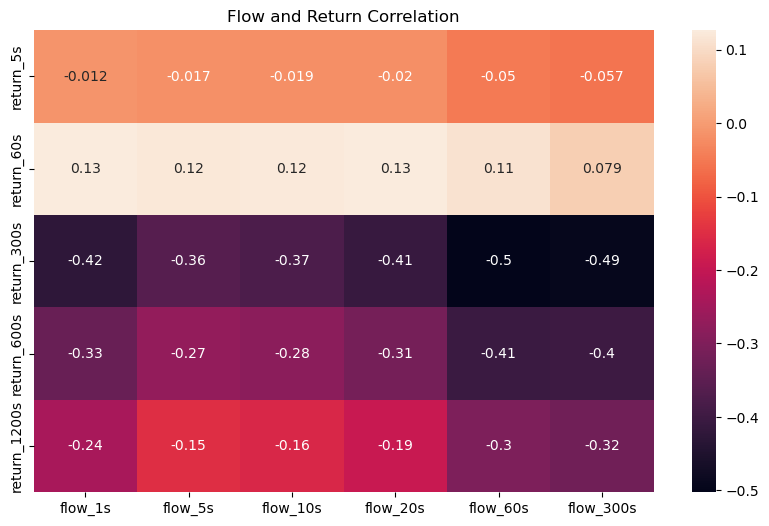

In [50]:
ETH_BTC_flow_train = ETH_BTC_flow.iloc[:int(split * len(ETH_BTC_flow))]
ETH_BTC_returns_train = ETH_BTC_returns.iloc[:int(split * len(ETH_BTC_returns))]

merged_ETH_BTC_flow_returns_train = pd.concat([ETH_BTC_flow_train.reset_index(drop=True), ETH_BTC_returns_train.reset_index(drop=True)], axis=1)
merged_ETH_BTC_flow_returns_corr = merged_ETH_BTC_flow_returns_train.corr().iloc[6:,:6]

plt.rcParams["figure.figsize"] = (10,6)
sns.heatmap(merged_ETH_BTC_flow_returns_corr, annot=True)
plt.title('Flow and Return Correlation')
plt.show()

### 5 Regression Analysis

In [16]:
def ols_stats(features, targets, intercept=False):
    features = features.astype(float)
    targets = targets.astype(float)

    if intercept:
        features = sm.add_constant(features)
        features.rename(columns={'const': 'alpha'}, inplace=True)

    ols_rsquared = pd.DataFrame()
    ols_coefficient = pd.DataFrame()

    for target in targets.columns:
        for feature in features.columns:
            Y = targets[target].reset_index(drop=True)
            X = features[feature].reset_index(drop=True)

            model = sm.OLS(Y, X, missing='drop')
            results = model.fit()
            ols_rsquared.loc[target, feature] = results.rsquared
            ols_coefficient.loc[target, feature] = results.params[0]

    return ols_rsquared, ols_coefficient, results

In [85]:
def get_ols_stats(x,y, split=0.4):
    x_train = x.iloc[:int(split*len(x))]
    y_train = y.iloc[:int(split*len(x))]
    #x_train /= 1e12
    
    return ols_stats(x_train, y_train)

In [18]:
get_ols_stats(ETH_BTC_flow, ETH_BTC_returns)[0]

,flow_1s,flow_5s,flow_10s,flow_20s,flow_60s,flow_300s
return_5s,0.000655,0.000906,0.000920,0.000948,0.003993,0.005057
return_60s,0.018317,0.018190,0.018649,0.019640,0.016991,0.010168
return_300s,0.161010,0.105573,0.115326,0.140989,0.197709,0.187503
return_600s,0.091296,0.050665,0.057584,0.073726,0.113847,0.104209
return_1200s,0.031890,0.005367,0.008165,0.014027,0.036077,0.037328


In [19]:
get_ols_stats(BTC_USD_flow, BTC_USD_returns)[0]

,flow_1s,flow_5s,flow_10s,flow_20s,flow_60s,flow_300s
return_5s,0.000101,0.000379,0.000394,0.000273,3.227226e-04,0.000214
return_60s,0.000008,0.000007,0.000002,0.000017,1.574229e-07,0.000541
return_300s,0.000395,0.001126,0.001382,0.001204,2.820488e-03,0.023146
return_600s,0.000961,0.002199,0.002517,0.002194,3.615491e-03,0.002739
return_1200s,0.000231,0.000257,0.000524,0.001569,3.045103e-03,0.000817


In [20]:
get_ols_stats(ETH_USD_flow, ETH_USD_returns)[0]

,flow_1s,flow_5s,flow_10s,flow_20s,flow_60s,flow_300s
return_5s,0.001480,0.005174,0.003810,0.003708,3.607629e-03,0.004068
return_60s,0.000169,0.000538,0.000574,0.000236,2.741383e-04,0.000868
return_300s,0.000017,0.000146,0.000081,0.000042,6.742476e-07,0.000670
return_600s,0.000147,0.000653,0.000847,0.000904,9.451138e-04,0.001900
return_1200s,0.000049,0.000003,0.000021,0.000043,4.177676e-05,0.000018


A brief inspection of the regression results show that none of the R-squared are larger than 20% which indicates that proportion of variation explained by the model $r^{T}_{i} = \beta \cdot F_{i}^{\tau}$ is not significantly large. We will pick the least among the evil ($\text{ETH-BTC}, \tau = 60s, T =300s, R^{2} = 19.77\%$) and interpret the regression results and possible pitfuls in the following notes. 

In [21]:
get_ols_stats(ETH_BTC_flow, ETH_BTC_returns)[1]

,flow_1s,flow_5s,flow_10s,flow_20s,flow_60s,flow_300s
return_5s,-9.641219e-07,-4.654816e-07,-4.203043e-07,-4.061735e-07,-6.187851e-07,-5.940448e-07
return_60s,8.056995e-06,3.294543e-06,2.990370e-06,2.920379e-06,2.016673e-06,1.330876e-06
return_300s,-3.959872e-05,-1.315728e-05,-1.232717e-05,-1.297073e-05,-1.140381e-05,-9.473798e-06
return_600s,-3.529700e-05,-1.078951e-05,-1.031120e-05,-1.110304e-05,-1.024365e-05,-8.360465e-06
return_1200s,-2.640262e-05,-4.444678e-06,-4.914254e-06,-6.129389e-06,-7.298272e-06,-6.332961e-06


From the coefficient table, we conclude the best regression model so far is 
<center> 

$r^{300s}_{i} = -1.140381 \cdot 10^{-05} \cdot F_{i}^{60s}$

</center>

In [25]:
result_ETH_BTC_60_300 = get_ols_stats(ETH_BTC_flow['flow_60s'].to_frame(),ETH_BTC_returns['return_300s'].to_frame())[2]
result_ETH_BTC_60_300.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            return_300s   R-squared (uncentered):                   0.198
Model:                            OLS   Adj. R-squared (uncentered):              0.197
Method:                 Least Squares   F-statistic:                              181.4
Date:                Mon, 26 Feb 2024   Prob (F-statistic):                    4.09e-37
Time:                        04:03:30   Log-Likelihood:                          4148.2
No. Observations:                 737   AIC:                                     -8294.
Df Residuals:                     736   BIC:                                     -8290.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
flow_60s    -1.14e-05   8.47e-07    -13.467      0.000   -1.31e-05   -9.74e-06
==============================================================================
Omnibus:                      245.047   Durbin-Watson:                   0.196
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1036.328
Skew:                          -1.489   Prob(JB):                    9.21e-226
Kurtosis:                       7.988   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 6 Beta Reliability Analysis

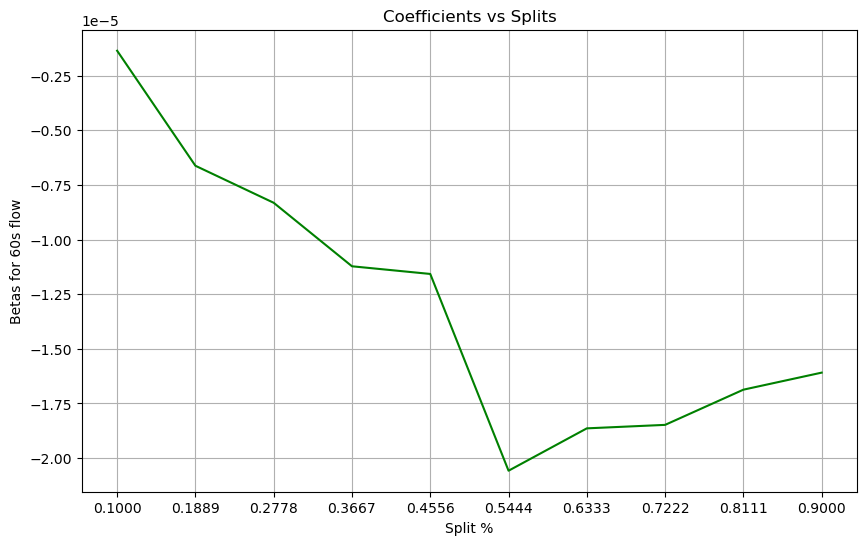

In [104]:
reg_betas = pd.DataFrame(columns=['Betas'])

# Iterate over different splits
for train_test_split in np.linspace(0.1, 0.9, 10):
    reg_results = get_ols_stats(ETH_BTC_flow['flow_60s'].to_frame(),ETH_BTC_returns['return_300s'].to_frame(), train_test_split)
    beta = reg_results[1].values[0][0]
    
    # Store beta value in DataFrame
    reg_betas.loc[train_test_split, 'Betas'] = beta

plt.figure(figsize=(10, 6))
plt.plot(reg_betas.index, reg_betas['Betas'], color='green', linestyle='-')
plt.title('Coefficients vs Splits')
plt.xlabel('Split %')
plt.ylabel('Betas for 60s flow')
plt.xticks(reg_betas.index)
plt.grid(True)
plt.show()

It would be meaningful to check the reliability of coefficients by varying the values of split ratio. The above graph shows that although coefficients are consistently negative across different split ratio, the drastic variations among them only stops after 54.44% split. This inspires me to use 54.44% as the new train-test split to make sure trading signal generations and position changes are meaningful in later backtesting stages.

### 7 Trading Strategy and Backtesting

Below we will align $r^{300s}_{i}$ and $F_{i}^{60s}$ and generate dataframe to prepare for backtesting flow-based return prediction trading strategy.

In [105]:
split = 0.5444

ETH_BTC_60_300_df = ETH_BTC_flow['flow_60s'].to_frame().copy()
ETH_BTC_60_300_df_test = ETH_BTC_60_300_df.iloc[int((1 - split)*len(ETH_BTC_60_300_df)):]

ETH_BTC_60_300_df_test['Predicted Returns'] = result_ETH_BTC_60_300.predict(ETH_BTC_60_300_df_test)
ETH_BTC_60_300_df_test = ETH_BTC_60_300_df_test.reset_index()

merged_ETH_BTC_60_300 = return_filter(filtered_trade_ETH_BTC_2023, filtered_book_ETH_BTC_2023, 300)
merged_ETH_BTC_60_300 = merged_ETH_BTC_60_300.dropna()

ETH_BTC_60_300_df_test = pd.merge_asof(ETH_BTC_60_300_df_test, merged_ETH_BTC_60_300, left_on='timestamp_utc_nanoseconds_trade', right_on='timestamp_utc_nanoseconds_book', direction='forward')
ETH_BTC_60_300_df_test = ETH_BTC_60_300_df_test[['timestamp_utc_nanoseconds_trade','timestamp_utc_nanoseconds_book', 'flow_60s', 'Predicted Returns', 'owa', 'return_300s']]
ETH_BTC_60_300_df_test.set_index('timestamp_utc_nanoseconds_trade',inplace=True)

ETH_BTC_60_300_df_test.drop(columns='timestamp_utc_nanoseconds_book', inplace=True)
ETH_BTC_60_300_df_test


/var/folders/zq/3znm38ld5sq9yk3f706q0l9r0000gp/T/ipykernel_71626/2905672374.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,flow_60s,Predicted Returns,owa,return_300s
timestamp_utc_nanoseconds_trade,,,,
1674596851544172000,-1.895689,2.161807e-05,0.070154,-0.000941
1674596857211019000,-4.523975,5.159054e-05,0.070154,-0.000941
1674596904821885000,-3.407121,3.885416e-05,0.070132,-0.001256
1674596906144328000,-3.999429,4.560872e-05,0.070132,-0.001256
1674596912958730000,-4.486925,5.116803e-05,0.070132,-0.001256
...,...,...,...,...
1674659220556309000,2.699892,-3.078904e-05,0.068455,0.000226
1674659233932491000,-0.087641,9.994393e-07,0.068474,0.001081
1674659254076843000,-0.005595,6.380202e-08,0.068470,0.001615


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


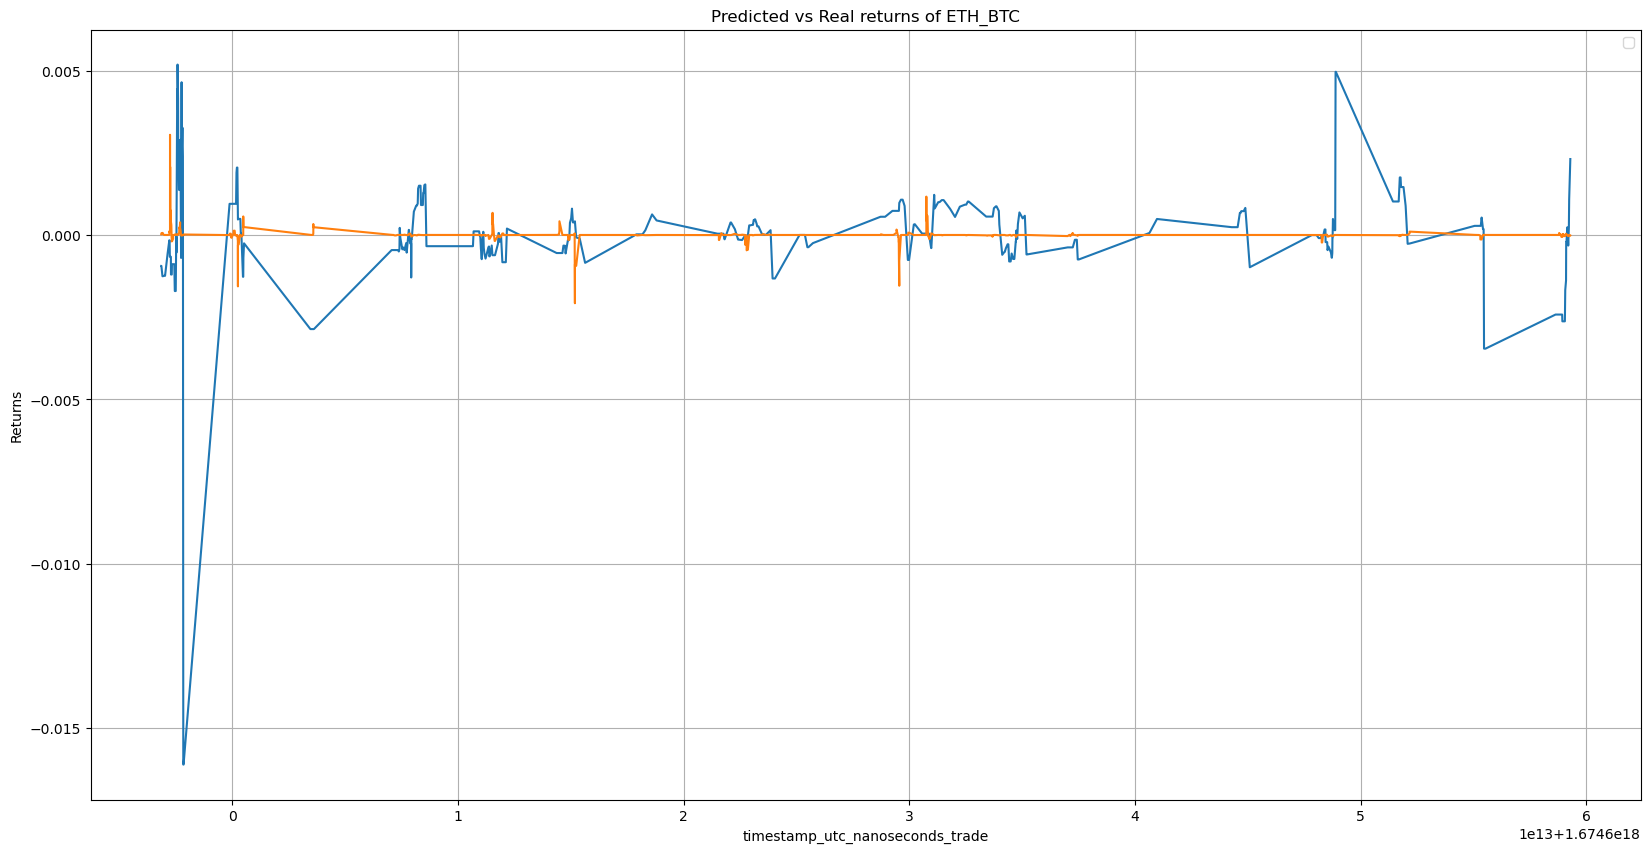

In [106]:
plt.figure(figsize = (20, 10))
plt.title('Predicted vs Real returns of ETH_BTC')
plt.plot(ETH_BTC_60_300_df_test['return_300s'])
plt.plot(ETH_BTC_60_300_df_test['Predicted Returns'])
plt.xlabel('timestamp_utc_nanoseconds_trade')
plt.ylabel('Returns')
plt.legend(loc = 'upper right')
plt.grid(True)
plt.show()

Inspection upon the slighly negative relationships betwen predicted and real returns indicates that it makes sense to adopt a simple trading strategy where we enter a long position when $\tilde{r}_{i}^{T} < -j$, short position when $\tilde{r}_{i}^{T} > j$ and flat when $|\tilde{r}_{i}^{T}| < j$.

In [134]:
def flow_return_strategy(df, j):
    trading_hist = df.copy()
    
    trading_hist['Position'] = trading_hist['Predicted Returns'].apply(lambda x: -1 if x > j else (1 if x < -j else 0))
    trading_hist['Minute returns'] = trading_hist['Position'] * trading_hist['return_300s']
    trading_hist['Cumulative Returns'] = (1 + trading_hist['Position'] * trading_hist['return_300s']).cumprod()
    
    return trading_hist

### 8 Optimization

In [135]:
ETH_BTC_60_300_df_test['Predicted Returns'].describe().to_frame()

,Predicted Returns
count,1.004000e+03
mean,5.421420e-05
std,3.473213e-04
min,-2.077194e-03
25%,-1.426347e-05
50%,5.649332e-09
75%,2.805621e-05
max,3.048417e-03


Given the range of predicted returns ([-2.077194e-03, 3.048417e-03]), it would be reasonable to use grid search to find the optimal value of $j$ the maximize the cumulative return of flow-based return prediction strategy.

In [109]:
def objective_function(j, df):
    temp_df = flow_return_strategy(df, j[0])  # Ensure j is passed as an array to the optimizer
    # Return the negative of the last cumulative returns to maximize it through minimization
    return temp_df['Cumulative Returns'].iloc[-1]

In [110]:
j_values = np.linspace(0, 0.003, 1000) 

# Initialize variables to store the best j and its corresponding objective value
j_opt = None
optimized_cum_ret = -np.inf  # Start with infinity since we are minimizing

# Perform the grid search
for j in j_values:
    current_objective_value = objective_function([j], ETH_BTC_60_300_df_test)
    if current_objective_value > optimized_cum_ret:
        j_opt = j
        optimized_cum_ret = current_objective_value

j_opt, optimized_cum_ret

(0.0, 1.3987878369263413)

### 9 Performance Analysis and Conclusion

In [136]:
ETH_BTC_60_300_strategy=flow_return_strategy(ETH_BTC_60_300_df_test, 0)
ETH_BTC_60_300_strategy

,flow_60s,Predicted Returns,owa,return_300s,Position,Minute returns,Cumulative Returns
timestamp_utc_nanoseconds_trade,,,,,,,
1674596851544172000,-1.895689,2.161807e-05,0.070154,-0.000941,-1,0.000941,1.000941
1674596857211019000,-4.523975,5.159054e-05,0.070154,-0.000941,-1,0.000941,1.001883
1674596904821885000,-3.407121,3.885416e-05,0.070132,-0.001256,-1,0.001256,1.003141
1674596906144328000,-3.999429,4.560872e-05,0.070132,-0.001256,-1,0.001256,1.004401
1674596912958730000,-4.486925,5.116803e-05,0.070132,-0.001256,-1,0.001256,1.005662
...,...,...,...,...,...,...,...
1674659220556309000,2.699892,-3.078904e-05,0.068455,0.000226,1,0.000226,1.401597
1674659233932491000,-0.087641,9.994393e-07,0.068474,0.001081,-1,-0.001081,1.400082
1674659254076843000,-0.005595,6.380202e-08,0.068470,0.001615,-1,-0.001615,1.397821


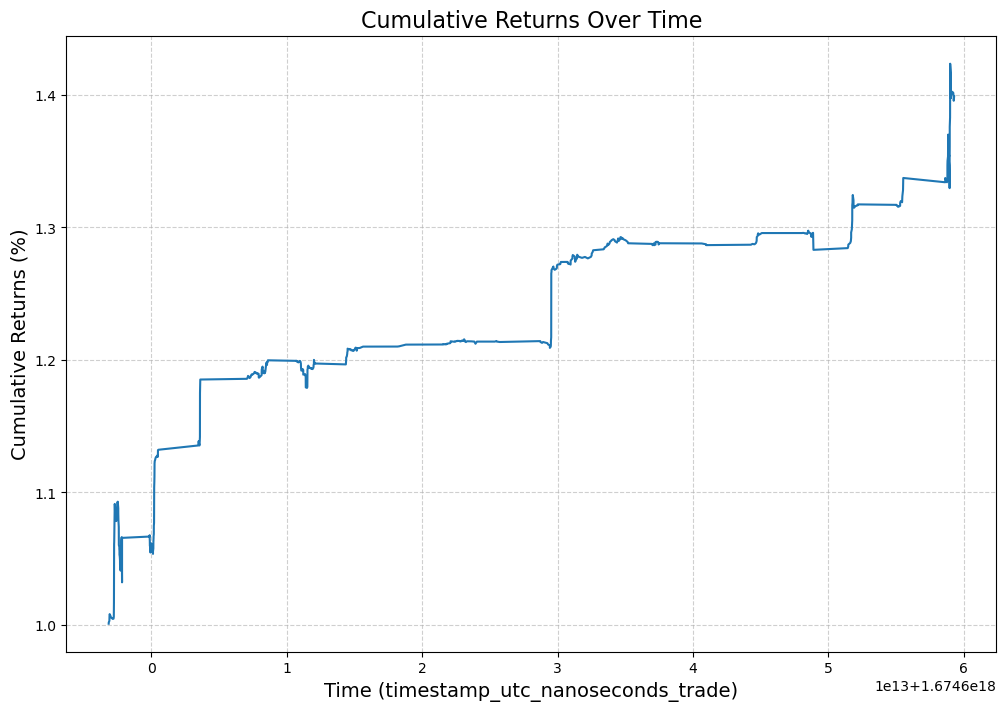

In [116]:
ETH_BTC_60_300_strategy_cum_return = flow_return_strategy(ETH_BTC_60_300_df_test, 0)['Cumulative Returns']
ETH_BTC_60_300_strategy_cum_return.plot(figsize=(12, 8))

plt.xlabel('Time (timestamp_utc_nanoseconds_trade)', fontsize=14)
plt.ylabel('Cumulative Returns (%)', fontsize=14)
plt.title('Cumulative Returns Over Time', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)

In [139]:
def performance_summary(returns_in):


    # Calculate daily returns from spreads
    returns = returns_in.copy()
    
    # Calculate statistics based on daily data without annualizing
    summary_stats = returns.mean().to_frame('Mean')
    summary_stats['Volatility'] = returns.std() 
    summary_stats['Sharpe Ratio'] = summary_stats['Mean'] / summary_stats['Volatility']  
    summary_stats['Skewness'] = returns.skew()
    summary_stats['Excess Kurtosis'] = returns.kurtosis()
    summary_stats['Min'] = returns.min()
    summary_stats['Max'] = returns.max()
    summary_stats['VaR 5%'] = returns.quantile(0.05)
    summary_stats['CVar 5%'] = returns[returns < returns.quantile(0.05)].mean()
    
    # Calculate drawdown
    wealth_index = 1000 * (1 + returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks
    summary_stats['Max Drawdown'] = drawdowns.min()
    
    return summary_stats

In [141]:
ETH_BTC_60_300_strategy_return = flow_return_strategy(ETH_BTC_60_300_df_test, 0)['Minute returns'].to_frame()

In [142]:
performance_summary(ETH_BTC_60_300_strategy_return)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Min,Max,VaR 5%,CVar 5%,Max Drawdown
Minute returns,0.000335,0.001518,0.220988,-0.486535,49.923663,-0.016116,0.016116,-0.001372,-0.003189,-0.055671


In [125]:
(pd.to_datetime(ETH_BTC_60_300_strategy_cum_return.index)[0], pd.to_datetime(ETH_BTC_60_300_strategy_cum_return.index)[-1])

(Timestamp('2023-01-24 21:47:31.544172'),
 Timestamp('2023-01-25 15:08:05.145749'))

Over the course 18 hours between 2023-01-24 21:47 to 2023-01-25 15:08, the flow-based return prediction trading strategy achieved a cumulative return of 39.87%. On the otherhand the strategy has achieved a meager 0.22 Sharpe ratio on minute basis. The negative skew (-0.486535) indiates a longer tail on the left side of mean. The high leptokurtosis distribution of historic returns indicates that there are higher probability of extreme returns. Combined with negative skewness, investors should prepare for consistent small gains and frequent large losses and adjust their risk expection accordingly.